# TP1: Parcours de protons dans la matière
## PHY-3500: Physique numérique (H2021) - 19 février 2021


Mélissa Cinq-Mars (111 179 946)

Pierre-Olivier Janvier (111 187 987)

Maxence Larose (111 188 447)

In [2]:
#import packages
import sympy as sym 
import scipy.constants as sc
from scipy.stats import moyal
import scipy.integrate as integrate
import numpy as np
import matplotlib.pyplot as plt
import timeit

### Question 1

On cherche à exprimer la densité électronique $n_{e}$ en fonction de sa composition atomique et de sa masse volumique $\rho$. On peut d'abord consulter les données du NIST afin de connaître les compositions atomiques de l'eau et de l'os compact ainsi que les énergies moyennes d'excitation $I$.  

On identifie pour l'eau (liquide):
- Densité $\rho$ (g/cm$^{3}$) = 1.00E+00
- Énergie d'excitation moyenne (eV) = 75.00
- Composition:
     - Numéro atomique 1 = 0.111894 (fraction par poids)
     - Numéro atomique 8 = 0.888106 (fraction par poids)

On identifie pour l'os compact (ICRU):
- Densité $\rho$ (g/cm$^{3}$) = 1.85E+00
- Énergie d'excitation moyenne (eV) = 91.90
- Composition:
    - Numéro atomique 1 = 0.063984
    - Numéro atomique 6 = 0.278000
    - Numéro atomique 7 = 0.027000
    - Numéro atomique 8 = 0.410016
    - Numéro atomique 12 = 0.002000
    - Numéro atomique 15 = 0.070000
    - Numéro atomique 16 = 0.002000
    - Numéro atomique 20 = 0.147000

On sait que la densité électronique d'un matériau peut être déterminé à l'aide de la formule suivante (https://en.wikipedia.org/wiki/Bethe_formula):

$$ n_e = \dfrac{N_A \cdot Z \cdot \rho}{A\cdot M_u}, $$

où $N_A$ est le nombre d'Avogadro, $Z$ est le numéro atomique, $A$ est la masse atomique relative et $M_u$ est la constante de masse molaire qui vaut 1 g/mol. 

Comme les matériaux observés sont composés de plusieurs éléments différents, on peut réécrire la densité électronique de la façon suivante:

$$ n_e = \dfrac{N_A \rho}{M_u} \sum_{i} \dfrac{Z_i \xi_{i}}{A_{i}}, $$

où $\xi$ est l'abondance relative de l'élément $i$ (Physique atomique et nucléaire, Jean-François Fortin). 

Par ailleurs, on sait que l'énergie cinétique est liée au facteur $\gamma$ de Lorentz de la façon suivante :

$$T = (\gamma - 1) m_0 c^2,$$

alors, on a évidemment que

$$\implies \gamma = \frac{T}{m_0 c^2} + 1.$$

On peut aussi lié les facteurs $\gamma$ et $\beta$ de Lorentz en sachant que

$$\gamma = \frac{1}{\sqrt{1 - \beta^2}},$$

et donc que

$$\implies \beta = \sqrt{1 - \frac{1}{\gamma^2}}.$$

On implémente l'ensemble des propriétés des deux milieux à l'étude dans une classe nommée « Medium ». Le calcul du pouvoir d'arrêt collisionnel sera réalisé dans cette classe.

In [3]:
class Medium:
    """
    Cette classe définit les propriétés des matériaux
    dans lesquels les protons sont propagés.
    """
    
    # Densité des milieux (rho) [g/cm^3]
    _densities: dict = {
        'Water': 1.0,
        'ICRU': 1.85
    }
    
    # Énergies moyennes d'excitation (I) [eV]
    _mean_excitation_energies: dict = {
        'Water': 75.00,
        'ICRU': 91.90
    }
    
    # Masse atomique relative de l'élément i (A_i) [-]
    _relative_atomic_mass: dict = {
        1: 1.00784,
        6: 12.0107,
        7: 14.0067,
        8: 15.999,
        12: 24.305,
        15: 30.9738,
        16: 32.065,
        20: 40.078,
    }
    
    # Composition de l'eau (Abondance relative, Xi) [-]
    _composition_water: dict = {
        1: 0.111894,
        8: 0.888106,
    }
    
    # Composition de l'os compact (Abondance relative, Xi) [-]
    _composition_ICRU: dict = {
        1: 0.063984,
        6: 0.278000,
        7: 0.027000,
        8: 0.410016,
        12: 0.002000,
        15: 0.070000,
        16: 0.002000,
        20: 0.147000,
    }
    
    # Dictionnaire des compositions
    _compositions: dict = {
        'Water': _composition_water,
        'ICRU': _composition_ICRU
    }
        
    
    def __init__(self, name: str) -> None:
        """
        Constructeur de la classe Medium.
        :param name: Nom du milieu dans lequel s'effectue la propagation
        """
        super().__init__()
        self.name: str = name
        
                
    @property
    def name(self) -> str:
        """
        Name property.
        :return: Nom du milieu (str)
        """
        
        return self._name
    
    
    @name.setter
    def name(self, name: str) -> None:
        """
        Setter de l'attribut name.
        :param name: Nom du milieu dans lequel s'effectue la propagation
        """
        
        if name not in Medium._compositions:
            raise NameError("Le matériau choisi n'est pas défini dans la classe. Choisir un autre matériau tel {}."
                            .format(list(Medium._compositions.keys())))
        else:
            self._composition: dict = Medium._compositions[name]
            self._mean_excitation_energy: float = Medium._mean_excitation_energies[name]
            self._density: float = Medium._densities[name]
        self._name = name
        
    
    @property
    def composition(self) -> dict:
        """
        Composition property.
        :return: Composition du milieu (dict)
        """
        
        return self._composition
    
    
    @property
    def mean_excitation_energy(self) -> float:
        """
        Mean excitation energy property.
        :return: Énergie d'excitation moyenne du milieu (float)
        """
        
        return self._mean_excitation_energy
    
    
    @property
    def density(self) -> float:
        """
        Density property.
        :return: Densité du milieu (float)
        """
        
        return self._density
    
    
    @staticmethod
    def get_gamma(T):
        """
        Getter du facteur gamma.
        :param T: Énergie cinétique du proton. (float or np.ndarray)
        :return: Facteur gamma. (float or np.ndarray)
        """
        
        m_p: float = sc.physical_constants["proton mass energy equivalent in MeV"][0]
        return T/(m_p) + 1.0
    
    
    @staticmethod
    def get_beta(T):
        """
        Getter du facteur beta.
        :param T: Énergie cinétique du proton. (float or np.ndarray)
        :return: Facteur beta (float or np.ndarray)
        """
            
        return np.sqrt(1 - Medium.get_gamma(T)**(-2))
    
    
    @staticmethod
    def get_Te_max(T):
        """
        Getter de l'énergie maximale transférable à un électron par un proton.
        :param T: Énergie cinétique du proton. (float or np.ndarray)
        :return: Énergie maximale transférable. (float or np.ndarray)
        """
            
        m_p: float = sc.physical_constants["proton mass energy equivalent in MeV"][0]
        m_e: float = sc.physical_constants["electron mass energy equivalent in MeV"][0]
        gamma: float = Medium.get_gamma(T)
        
        num = 2*m_e*(gamma**2 - 1)
        denum = 1 + 2*gamma*m_e/m_p + (m_e/m_p)**2
        
        return num/denum
    
    
    def get_electronic_density(self) -> float:
        """
        Getter de la densité électronique du milieu.
        :return: Densité électronique du milieu. (float)
        """
        
        N_A: float = sc.N_A
        
        summation: list = []
        for Z_i, xi_i in self._composition.items():
            
            A_i = Medium._relative_atomic_mass[Z_i]
            
            summation.append(Z_i*xi_i/A_i)

        return self._density*N_A*np.sum(summation)
    
    
    def get_Scol(self, T):
        """
        Getter du pouvoir d'arrêt collisionnel du milieu.
        :param T: Énergie cinétique du proton. (float or np.ndarray)
        :return: Pouvoir d'arrêt collisionnel. (float or np.ndarray)
        """
        
        r_e: float = sc.physical_constants["classical electron radius"][0] * 100 # [cm]
        m_e: float = sc.physical_constants["electron mass energy equivalent in MeV"][0] # [MeV] 
        
        gamma = self.get_gamma(T) # [-]
        beta = self.get_beta(T) # [-]
        Te_max = self.get_Te_max(T) # [MeV]
        n_e = self.get_electronic_density() # [cm^-3]
        I = self._mean_excitation_energy/1e6 # [MeV]
        
        coeff = 2*np.pi*(r_e**2)*m_e*n_e*(beta**(-2))
        arg = (2*m_e*(beta**2)*(gamma**2)*Te_max)/(I**2)
        
        return coeff*(np.log(arg) - 2*beta**2)
    
    
    
    def plot_Scol(self):
        """
        Trace la figure du pouvoir d'arrêt collisionnel du milieu en fonction de l'énergie cinétique 
        des protons incidents.
        """
        
        min_energy = 3
        max_energy = 250
        T = np.arange(min_energy, max_energy, 0.01)

        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(1, 1, 1)
        
        line, = ax.plot(T, self.get_Scol(T), color='k', lw=2)
        ax.set_xscale('log')
        
        if self.name == 'Water':
            ax.set_title("Propagation dans l'eau", fontsize=14)
        elif self.name == 'ICRU':
            ax.set_title("Propagation dans l'os compact (ICRU)", fontsize=14)
        else:
            raise NameError('Matériau inconnu')
        
        ax.set_xlabel("Énergie du proton $T$ [$MeV$]", fontsize=14)
        ax.set_xlim([min(T), max(T)])
        ax.set_ylabel("Pouvoir d'arrêt collisionnel $S_{col}(T)$ \n [$MeV/cm$]", fontsize=14)
        ax.minorticks_on()

        plt.grid()
        plt.show()
        plt.close(fig)


Il est ensuite possible d'utiliser la classe définie précédemment pour tracer les courbes de pouvoir d'arrêt collisionnel $S_{col}(T)$. Il est important de noter que l'énergie minimale est choisie comme étant 3 MeV, puisque c'est la limite de validité de l'approximation utilisée dans les calculs. La borne supérieure est choisie à 250 MeV sachant que les accélérateurs produisent des faisceaux dans la gamme de 70-250 MeV.

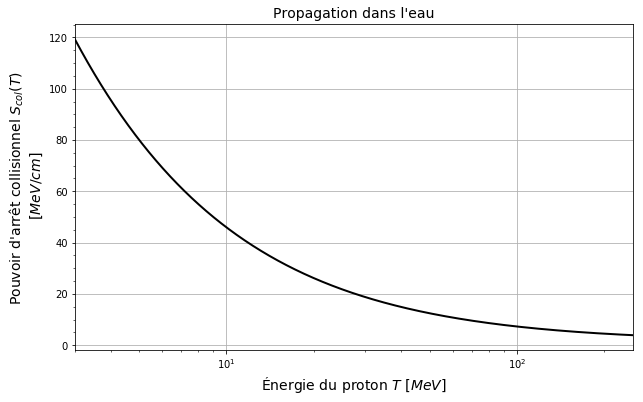

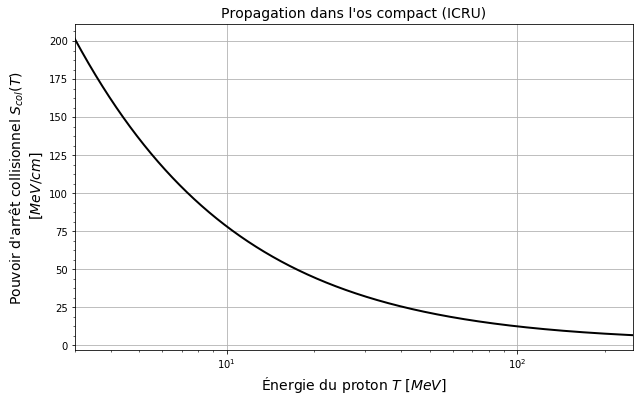

In [4]:
water = Medium(name='Water')
water.plot_Scol()

icru = Medium(name='ICRU')
icru.plot_Scol()

## Portée des protons dans la matière

### Question 2

On désire faire l'analyse dimensionnelle de l'équation de la portée des protons dans la matière. On dira que la portée $R_{CSDA}$ est de dimensions homogènes s'il existe un facteur, sans unité la liant au terme de l'intégrale de l'inverse du pouvoir d'arrêt total donné par

$$ R_{C S D A}=\int_{0}^{T_{i}} \frac{\mathrm{dT}^{\prime}}{\frac{S_{c o l}}{\rho}} , $$

où, on sait que la portée $R_{CSDA}$ est exprimée en $[g/cm^2]$ (https://physics.nist.gov/PhysRefData/Star/Text/PSTAR.html) et que le pouvoir d'arrêt total est quant à lui exprimé en  $[MeV/cm]$. On obtient donc l'analyse dimensionnelle suivante:

- $MeV$ = $J$ = $kg m^2 s^{-2}$ = $ ML^2T^{-2}$

- $cm$ = $L$

- $g$ = $M$

$$ \dfrac{M L^{-3}}{ML^2 T^{-2} L^{-1}} \cdot ML^2 T^{-2} =  M L^{-2}, $$

ce qui correspond effectivement aux dimensions obtenues avec la portée $R_{CSDA}$ en $[g/cm^2]$. 




### Question 3 

Il est possible de justifier le fait que le pouvoir d'arrêt total est bien approximé par le pouvoir d'arrêt collisionnel aux énergies de la protonthérapie en visualisant l'ordre de grandeur des pouvoirs d'arrêt collisionnels massiques dus aux différentes interactions du proton. Pour ce faire, les courbes présentées sur le site du NIST pour l'eau et l'os compact (IRCU) sont utilisées. Le bloc suivant permet de tracer les courbes pour l'eau, puis le bloc suivant pour l'os compact.

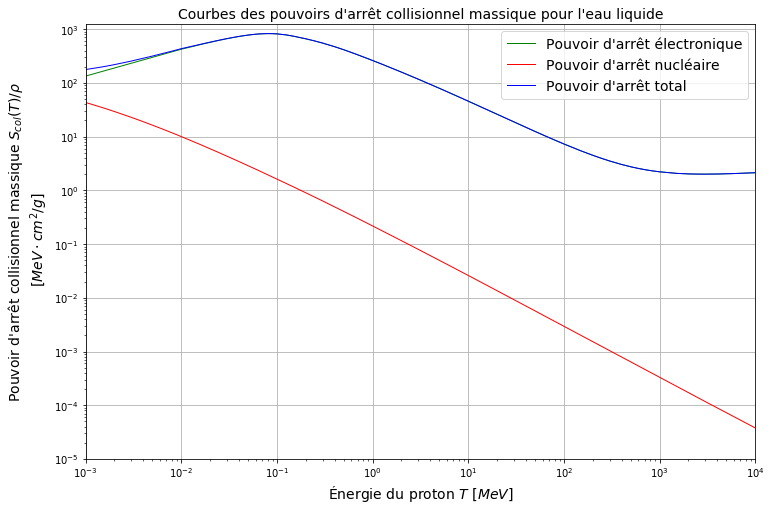

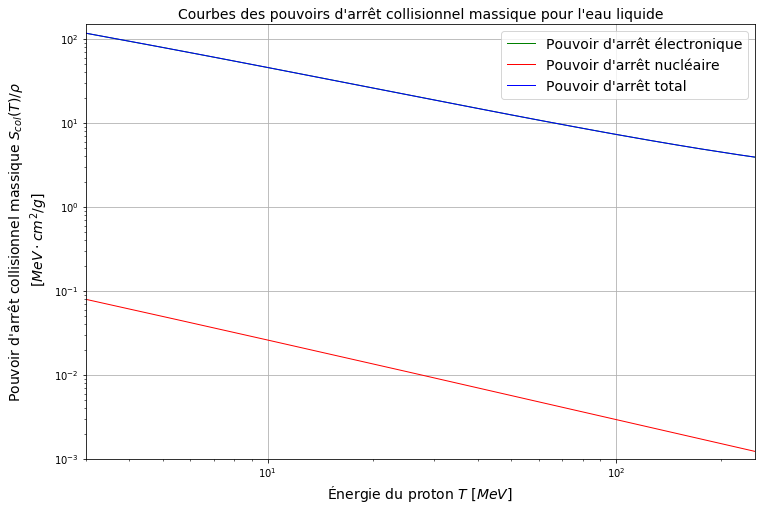

In [5]:
NIST_WATER = np.loadtxt(fname='Data/NIST_WATER.txt', skiprows=8)

min_energy = 3
max_energy = 250

x_bounds = [[min(NIST_WATER[:,0]), max(NIST_WATER[:,0])], [min_energy, max_energy]] 
y_bounds = [[0.00001, max(NIST_WATER[:,3]) + 0.5*max(NIST_WATER[:,3])], [0.001, 150]]

for xlims, ylims in zip(x_bounds, y_bounds):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1)

    line_1, = ax.plot(NIST_WATER[:,0], NIST_WATER[:,1], color='g', lw=1, ls='-', label="Pouvoir d'arrêt électronique")
    line_2, = ax.plot(NIST_WATER[:,0], NIST_WATER[:,2], color='r', lw=1, ls='-', label="Pouvoir d'arrêt nucléaire")
    line_3, = ax.plot(NIST_WATER[:,0], NIST_WATER[:,3], color='b', lw=1, ls='-', label="Pouvoir d'arrêt total")

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title("Courbes des pouvoirs d'arrêt collisionnel massique pour l'eau liquide", fontsize=14)
    ax.set_xlabel("Énergie du proton $T$ [$MeV$]", fontsize=14)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_ylabel("Pouvoir d'arrêt collisionnel massique $S_{col}(T)/ ρ$ \n [$MeV \cdot cm^2/g$]", fontsize=14)
    ax.legend(fontsize=14)
    ax.minorticks_on()

    plt.grid()
    plt.show()
    plt.close(fig)

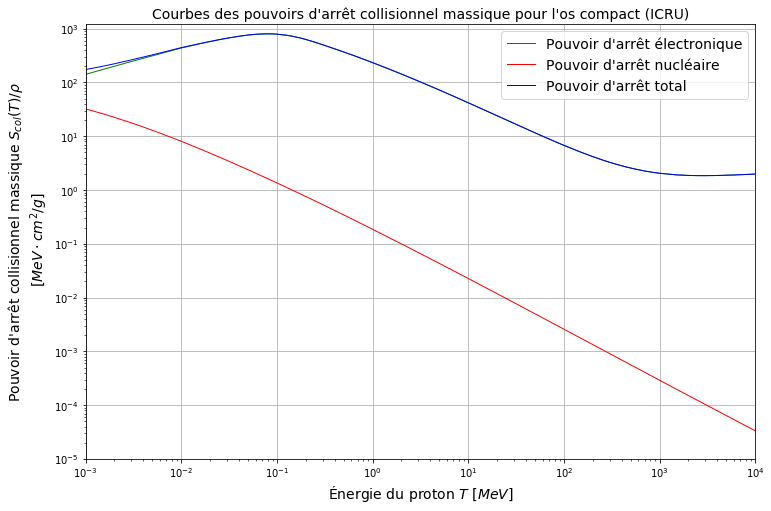

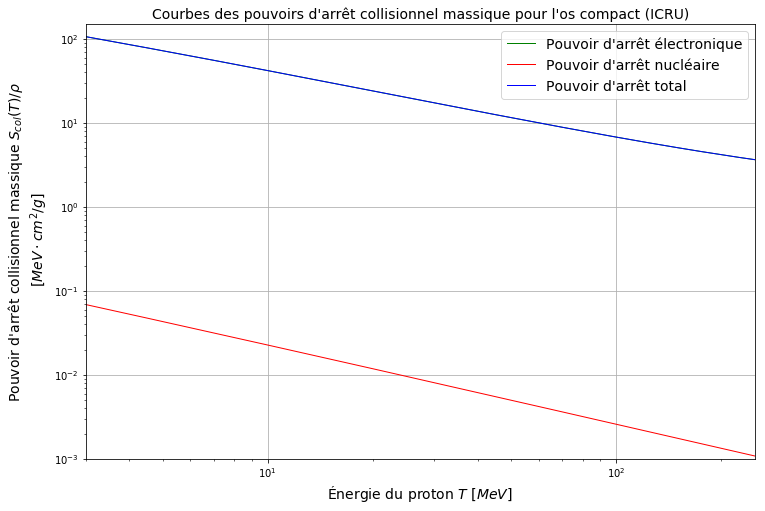

In [6]:
NIST_ICRU = np.loadtxt(fname='Data/NIST_ICRU.txt', skiprows=8)

min_energy = 3
max_energy = 250

x_bounds = [[min(NIST_ICRU[:,0]), max(NIST_ICRU[:,0])], [min_energy, max_energy]] 
y_bounds = [[0.00001, max(NIST_ICRU[:,3]) + 0.5*max(NIST_WATER[:,3])], [0.001, 150]]

for xlims, ylims in zip(x_bounds, y_bounds):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1)

    line_1, = ax.plot(NIST_ICRU[:,0], NIST_ICRU[:,1], color='g', lw=1, ls='-', label="Pouvoir d'arrêt électronique")
    line_2, = ax.plot(NIST_ICRU[:,0], NIST_ICRU[:,2], color='r', lw=1, ls='-', label="Pouvoir d'arrêt nucléaire")
    line_3, = ax.plot(NIST_ICRU[:,0], NIST_ICRU[:,3], color='b', lw=1, ls='-', label="Pouvoir d'arrêt total")

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title("Courbes des pouvoirs d'arrêt collisionnel massique pour l'os compact (ICRU)", fontsize=14)
    ax.set_xlabel("Énergie du proton $T$ [$MeV$]", fontsize=14)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_ylabel("Pouvoir d'arrêt collisionnel massique $S_{col}(T)/ ρ$ \n [$MeV \cdot cm^2/g$]", fontsize=14)
    ax.legend(fontsize=14)
    ax.minorticks_on()

    plt.grid()
    plt.show()
    plt.close(fig)

Le comportement des pouvoirs d'arrêt collisionnels est semblable pour l'eau et l'os compact (ICRU). On remarque que, aux énergies de la protonthérapie, le pouvoir d'arrêt collisionnel massique dû aux interactions nucléaires et pertes radiatives est d'environ 1000 fois plus faible que celui engendré par les interactions électroniques. Il est donc justifiable de les négliger dans notre calcul.

Afin de valider l'approximation utilisée dans les calculs réalisés à la question 1, il est possible de tracer les courbes calculées et les courbes provenant des données du NIST sur la même figure et pour le même intervalle d'énergie. Il est important de noter que les courbes précédemment obtenues doivent être divisées par la densité du milieu correspondant puisque les courbes du NIST sont celles du pouvoir collisionnel *massique* qui s'exprime comme $\frac{S_{col}}{\rho}$. Par ailleurs, les courbes du NIST utilisées sont celles du pouvoir collisionnel massique *total*. Bien que nos calculs tiennent en compte seulement les interactions électroniques et non les réactions nucléaires et les pertes radiatives des protons, le pouvoir collisionnel massique *total* est utilisé puisque, tel que discuté précédemment, les interactions nucléaires et radiatives sont négligeables aux énergies de protonthérapie.

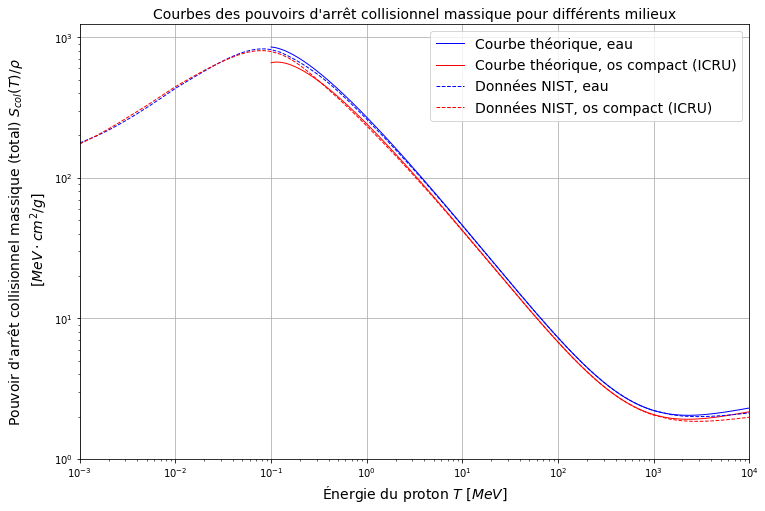

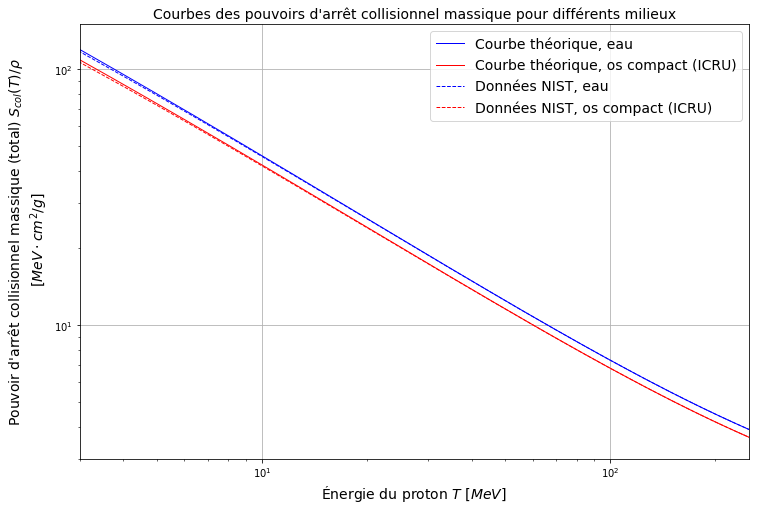

In [7]:
NIST_ICRU = np.loadtxt(fname='Data/NIST_ICRU.txt', skiprows=8)
NIST_WATER = np.loadtxt(fname='Data/NIST_WATER.txt', skiprows=8)

min_energy = 3
max_energy = 250
T = np.arange(0.1, 10000, 0.01)
icru_Scol_mass = icru.get_Scol(T)/icru.density
water_Scol_mass = water.get_Scol(T)/water.density

x_bounds = [[min(NIST_WATER[:,0]), max(NIST_WATER[:,0])], [min_energy, max_energy]] 
y_bounds = [[1, max(NIST_WATER[:,3]) + 0.5*max(NIST_WATER[:,3])], [3, 150]]

for xlims, ylims in zip(x_bounds, y_bounds):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1)

    line_1, = ax.plot(T, water_Scol_mass, color='b', lw=1, label='Courbe théorique, eau')
    line_2, = ax.plot(T, icru_Scol_mass, color='r', lw=1, label='Courbe théorique, os compact (ICRU)')
    line_3, = ax.plot(NIST_WATER[:,0], NIST_WATER[:,3], color='b', lw=1, ls='--', label='Données NIST, eau')
    line_4, = ax.plot(NIST_ICRU[:,0], NIST_ICRU[:,3], color='r', lw=1, ls='--', label='Données NIST, os compact (ICRU)')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title("Courbes des pouvoirs d'arrêt collisionnel massique pour différents milieux", fontsize=14)
    ax.set_xlabel("Énergie du proton $T$ [$MeV$]", fontsize=14)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_ylabel("Pouvoir d'arrêt collisionnel massique (total) $S_{col}(T)/ ρ$ \n [$MeV \cdot cm^2/g$]", fontsize=14)
    ax.legend(fontsize=14)
    ax.minorticks_on()

    plt.grid()
    plt.show()
    plt.close(fig)

On remarque que les courbes se rapprochent bien dans l'intervalle où l'approximation utilisée (négliger les termes correctifs) est valide, soit pour des énergies de proton de plus de 3 MeV.

### Question 4

Une méthode numérique est nécessaire pour calculer la portée des protons puisque l'intégrale est difficile (voir impossible) à réaliser analytiquement. En effet, il est nécessaire d'intégrer l'inverse du pouvoir collisionnel massique en fonction de l'énergie d'un proton $T$. Le pouvoir collisionnel est donné par 

$$ S_{c o l}(T)=2 \pi r_{e}^{2} m_{e} c^{2} n_{e} \frac{1}{\beta^{2}}\left[\ln \left(\frac{\left.2 m_{e} c^{2} \beta^{2} \gamma^{2} T_{e}^{\max }\right)}{I^{2}}\right)-2 \beta^{2}\right] $$

Dans cette équation, les termes $\gamma$, $\beta$ et $T_{e}^{\max }$ ont tous une dépendance en énergie $T$, ce qui rend la résolution analytique complexe. La méthode d'intégration numérique permet d'éviter le calcul de l'intégral puisqu'elle permet de ne faire que des évaluations de la fonction.

### Question 5


On cherche à calculer la portée des protons dans l'eau et dans l'os compact avec la méthode des trapèzes et la méthode de Simpson. On sait que la portée $R_{CSDA}$ est donnée par

$$ R_{C S D A}=\int_{0}^{T_{i}} \frac{\mathrm{dT}^{\prime}}{\frac{S_{c o l}}{\rho}}. $$

On considère des protons de 150 MeV, ce qui signifie que $T_i = 150$ MeV dans l'équation précédente. L'approximation utilisé pour le pouvoir collisionnel fonctionne seulement pour les protons de plus de 3 MeV et on utilisera donc une borne inférieure d'intégration de 3 MeV plutôt que de 0 MeV.

La classe suivante permet de réaliser l'intégration d'une fonction quelconque, et ce, soit par la méthode des trapèzes ou de Simpson. L'algorithme double le nombre de tranches à chaque évaluation de l'intégrale jusqu'à obtenir l'erreur voulue, qui est l'erreur de l'ordre de la précision machine par défaut. La sortie de cette fonction peut être un dictionnaire comprennant une liste du nombre d'échantillons utilisé, une liste des valeurs de l'intégrale selon le nombre de tranches et une liste de l'erreur correspondante. Le dernier élément de cette liste correspond à la valeur de l'intégrale à l'erreur voulue.

N.B: Il est important de noter que la technique de nesting a été utilisée afin d'accélérer les calculs réalisés par les 2 méthodes.

In [8]:
class Integration:
    """
    Cette classe comprend deux algorithmes d'intégration numérique permettant 
    de calculer la portée de protons dans l'eau et dans l'os compact. 
    """
    
    
    def __init__(self, function) -> None:
        """
        Construction de la classe Integration.
        :param func: Fonction mathématique à intégrer
        :param algo: Type d'algorithme que l'on désire utiliser; méthode trapèze, méthode Simpson (str)
        """
        
        self._function = function

        self.integration_algos: dict = {
            "trapeze": self.trapeze_integration,
            "simpson": self.simpson_integration
        }
            

    @property
    def function(self) -> str:
        """
        Function property.
        :return: Nom de la fonction à intégrer (str)
        """
        
        return self._function.__name__

    
    @staticmethod
    def get_output(output_dict, output_format: str):
        """
        Retourne soit un dictionnaire ou un tuple, selon le format désiré.
        :param output_format: Format de la sortie de la fonction désirée parmi 'tuple' et 'dict' (str)
        :param output_dict: Le dictionnaire des valeurs de sortie avec les clés N, Integral, Error (dict)
        :return: Nom de la fonction à intégrer (str)
        """
        
        if output_format == "tuple":
            return output_dict["Integral"][-1], output_dict["Error"][-1] 
        elif output_format == "dict":
            return output_dict
        else:
            raise AttributeError("Choisir un nom valide pour la variable output_format, soit 'tuple' ou dict'")
    
    
    def integrate(self, algo: str, *args, **kwargs) -> float:
        """
        Retourne l'intégrale de la fonction avec l'algorithme choisi.
        :param algo: Type d'algorithme que l'on désire utiliser; méthode trapèze, méthode Simpson (str)
        """
        
        if algo not in self.integration_algos:
            raise NameError("L'algorithme choisi n'est pas défini dans la classe. Choisir un autre algo tel {}."
                            .format(list(self.integration_algos.keys())))
        else:
            pass

        return self.integration_algos[algo](*args, **kwargs)

        
    def trapeze(self, N: int, a: float, b: float) -> float:
        """
        Réalise l'intégrale de la fonction courante avec la méthode des trapèzes.
        :param N: Nombre de tranches utilisé pour calculer l'intégrale (int)
        :param a: Borne inférieure de l'intégrale (float)
        :param b: Borne supérieure de l'intégrale (float)
        :return I: La valeur de l'intégrale calculé (float)
        """
        
        X: np.ndarray = np.linspace(a, b, N+1)[1:-1]
        Y = self._function(X)

        h = (b - a)/N

        I = h*(0.5*self._function(a) + 0.5*self._function(b) + np.sum(Y))
    
        return I
    
    
    def adap_trapeze(self, N: int, prev_estimate: float, a: float, b: float):
        """
        Réalise l'intégrale de la fonction courante avec le nesting de la méthode des trapèzes.
        :param N: Nombre de tranches utilisé pour calculer l'intégrale (int)
        :param prev_estimate: Valeur de l'intégrale calculé à l'itération précédente (float)
        :param a: Borne inférieure de l'intégrale (float)
        :param b: Borne supérieure de l'intégrale (float)
        :return I: La valeur de l'intégrale calculé (float)
        """
        
        X = np.linspace(a, b, N+1)[1:-1:2]
        Y = self._function(X)
        
        h = (b - a)/N
        
        I = 1/2*prev_estimate + h*np.sum(Y)
        
        return I

    
    def trapeze_integration(self, error_target = "machine_epsilon", output_format: str = "tuple",*args, **kwargs):
        """
        Réalise l'intégrale de la fonction courante avec la méthode des trapèzes en utilisant du nesting
        :param error_target: La valeur de l'erreur maximale à atteindre (float) ou default -> "machine_epsilon" (string)
                             La valeur "machine_epsilon" signifie qu'on veut atteindre la précision machine. 
        :param output_format: Format de la sortie de la fonction désirée parmi 'tuple' et 'dict' (str) default -> 'tuple'
        :return: Dictionnaire contenant les listes Integral_list, N_list, Error_list (dict) OU
                 tuple de la valeur de l'intégrale finale et l'erreur finale obtenue (float, float):
                 
                     Integral_list: Les valeurs des intégrales calculées par la méthode de Simpson (list)
                     N_list: Les nombres de segments utilisés dans chacun des calculs d'intégral (list)
                     Error_list: Les erreurs pratiques calculées à chaque itération (list)
                     
                     (Integral, Error): Valeur finale de l'intégrale et de l'erreur pratique calculée par 
                                        la méthode des trapèzes (float, float)  
        """
        
        Ni = 1
        prev_estimate = self.trapeze(N=Ni, *args, **kwargs)
        
        output_dict = {
            "N": [],
            "Integral": [],
            "Error": []
        }

        max_iter = 1000
        for i in range(1, max_iter):
            Ni *= 2
            integral = self.adap_trapeze(N=Ni, prev_estimate=prev_estimate, *args, **kwargs)

            epsilon = (1/3)*(integral - prev_estimate)

            error = abs(epsilon)
            
            output_dict["N"].append(Ni)
            output_dict["Integral"].append(integral)
            output_dict["Error"].append(error)
            
            if error_target == "machine_epsilon":
                error_goal = integral*np.finfo(float).eps
            else:
                error_goal = error_target

            if error > error_goal:
                pass
            else:
                break

            prev_estimate = integral
        
        return self.get_output(output_dict, output_format)


    def simpson(self, N: int, a: float, b: float):
        """
        Réalise l'intégrale de la fonction courante avec la méthode de Simpson.
        :param N: Nombre de tranches utilisé pour calculer l'intégrale (int)
        :param a: Borne inférieure de l'intégrale (float)
        :param b: Borne supérieure de l'intégrale (float)
        :return I: La valeur de l'intégrale calculé (float)
        """
        
        X_odd = np.linspace(a, b, N+1)[1:-1:2]
        X_even = np.linspace(a, b, N+1)[2:-2:2]
        Yodd = self._function(X_odd)
        Yeven = self._function(X_even)

        h = (b - a)/N

        I = 1/3*h*(self._function(a) + self._function(b) + 4*np.sum(Yodd) + 2*np.sum(Yeven))
        
        return I


    def adap_simpson(self, N: int, S_prev_estimate: float, T_prev_estimate: float,  a: float, b: float):
        """
        Réalise l'intégrale de la fonction courante avec le nesting de la méthode de Simpson.
        :param N: Nombre de tranches utilisé pour calculer l'intégrale (int)
        :param S_prev_estimate: Valeur de la variable S obtenue à l'itération précédente (float)
        :param T_prev_estimate: Valeur de la variable T obtenue à l'itération précédente (float)
        :param a: Borne inférieure de l'intégrale (float)
        :param b: Borne supérieure de l'intégrale (float)
        :return I, S, T: La valeur de l'intégrale calculé, de la variable S et de la variable T (float, float, float)
        """
        
        X_even = np.linspace(a, b, N+1)[2:-2:2]
        X_odd = np.linspace(a, b, N+1)[1:-1:2]
        Yeven = self._function(X_even)
        Yodd = self._function(X_odd)
        h = (b - a)/N

        S = S_prev_estimate + T_prev_estimate
        T = 2/3*(np.sum(Yodd))
        I = h*(S + 2*T)

        return I, S, T

    
    def simpson_integration(self, error_target = "machine_epsilon", output_format: str = "tuple", *args, **kwargs):
        """
        Réalise l'intégrale de la fonction courante avec la méthode de Simpson en utilisant du nesting.
        :param error_target: La valeur de l'erreur maximale à atteindre (float) ou default -> "machine_epsilon" (string)
                             La valeur "machine_epsilon" signifie qu'on veut atteindre la précision machine. 
        :param output_format: Format de la sortie de la fonction désirée parmi 'tuple' et 'dict' (str) default -> 'float'
        :return: Dictionnaire contenant les listes Integral_list, N_list, Error_list (dict) OU
                 tuple de la valeur de l'intégrale finale et l'erreur finale obtenue (float, float):
                 
                     Integral_list: Les valeurs des intégrales calculées par la méthode de Simpson (list)
                     N_list: Les nombres de segments utilisés dans chacun des calculs d'intégral (list)
                     Error_list: Les erreurs pratiques calculées à chaque itération (list)
                     
                     (Integral, Error): Valeur finale de l'intégrale et de l'erreur pratique calculée par 
                                        la méthode de Simpson (float, float)  
        """
        
        Ni = 1
        
        assert "a" in kwargs and "b" in kwargs
        a = kwargs["a"]
        b = kwargs["b"]

        X_even = np.linspace(a, b, Ni+1)[2:-2:2]
        X_odd = np.linspace(a, b, Ni+1)[1:-1:2]
        Yeven = self._function(X_even)
        Yodd = self._function(X_odd)

        S_prev_estimate = 1/3*(self._function(a) + self._function(b) + 2*np.sum(Yeven))
        T_prev_estimate = 2/3*(np.sum(Yodd))

        prev_estimate = self.simpson(N=Ni, a=a, b=b)

        output_dict = {
            "N": [],
            "Integral": [],
            "Error": []
        }

        max_iter = 1000
        for i in range(1, max_iter):
            Ni *= 2

            integral, S, T = self.adap_simpson(N=Ni, S_prev_estimate=S_prev_estimate, T_prev_estimate=T_prev_estimate, 
                                               a=a, b=b)

            epsilon = (1/15)*(integral - prev_estimate)

            error = abs(epsilon)
            
            output_dict["N"].append(Ni)
            output_dict["Integral"].append(integral)
            output_dict["Error"].append(error)

            if error_target == "machine_epsilon":
                error_goal = integral*np.finfo(float).eps
            else:
                error_goal = error_target

            if error > error_goal:
                pass
            else:
                break

            prev_estimate = integral
            S_prev_estimate = S
            T_prev_estimate = T
        
        return self.get_output(output_dict, output_format)


In [9]:
min_energy = 3
max_energy = 150

water = Medium(name="Water")
water_integration = Integration(lambda T: water.density/water.get_Scol(T))

water_trapeze_integral = water_integration.integrate(algo='trapeze', a=min_energy, b=max_energy, output_format="dict")
water_simpson_integral = water_integration.integrate(algo='simpson', a=min_energy, b=max_energy, output_format="dict")

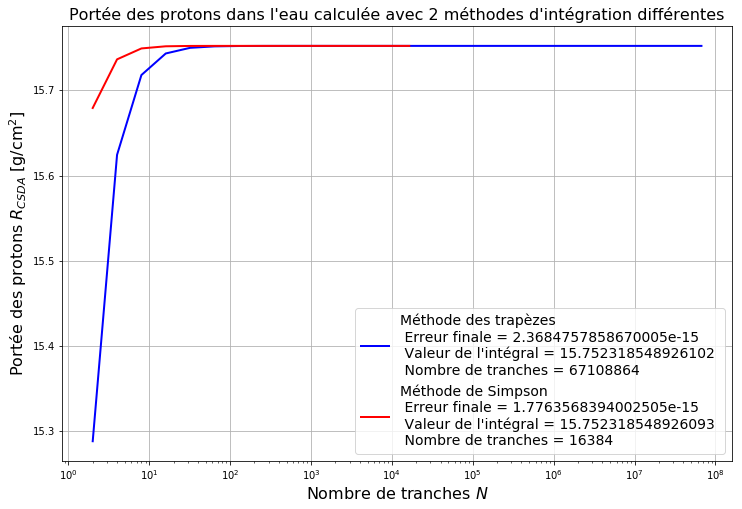

In [10]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)

R_trapeze, = ax.plot(water_trapeze_integral["N"], water_trapeze_integral["Integral"], linestyle='-', 
                     color='b', linewidth='2', 
                     label="Méthode des trapèzes \n Erreur finale = {} \n Valeur de l'intégral = {} \n Nombre de tranches = {} "
                     .format(water_trapeze_integral["Error"][-1], 
                             water_trapeze_integral["Integral"][-1], 
                             water_trapeze_integral["N"][-1])
                    )

R_simpson, = ax.plot(water_simpson_integral["N"], water_simpson_integral["Integral"], linestyle='-', 
                     color='r', linewidth='2', 
                     label="Méthode de Simpson \n Erreur finale = {} \n Valeur de l'intégral = {} \n Nombre de tranches = {} "
                     .format(water_simpson_integral["Error"][-1], 
                             water_simpson_integral["Integral"][-1], 
                             water_simpson_integral["N"][-1])
                    )

ax.set_title("Portée des protons dans l'eau calculée avec 2 méthodes d'intégration différentes", fontsize=16)
ax.set_xscale('log')
ax.set_xlabel("Nombre de tranches $N$", fontsize=16)
ax.set_ylabel("Portée des protons $R_{CSDA}$ [g/cm$^{2}$]", fontsize=16)
ax.legend(handles=[R_trapeze, R_simpson], fontsize=14, loc='best')

plt.grid()
plt.show()
plt.close(fig)


In [11]:
icru = Medium(name="ICRU")
icru_integration = Integration(lambda T: icru.density/icru.get_Scol(T))

icru_trapeze_integral = icru_integration.integrate(algo='trapeze', a=min_energy, b=max_energy, output_format="dict")
icru_simpson_integral = icru_integration.integrate(algo='simpson', a=min_energy, b=max_energy, output_format="dict")

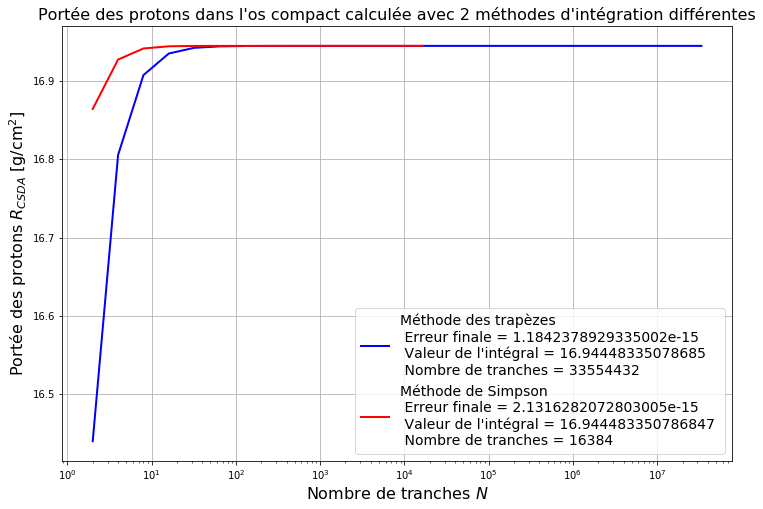

In [12]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)

R_trapeze, = ax.plot(icru_trapeze_integral["N"], icru_trapeze_integral["Integral"], linestyle='-', 
                     color='b', linewidth='2', 
                     label="Méthode des trapèzes \n Erreur finale = {} \n Valeur de l'intégral = {} \n Nombre de tranches = {} "
                     .format(icru_trapeze_integral["Error"][-1], 
                             icru_trapeze_integral["Integral"][-1], 
                             icru_trapeze_integral["N"][-1])
                    )

R_simpson, = ax.plot(icru_simpson_integral["N"], icru_simpson_integral["Integral"], linestyle='-', 
                     color='r', linewidth='2', 
                     label="Méthode de Simpson \n Erreur finale = {} \n Valeur de l'intégral = {} \n Nombre de tranches = {} "
                     .format(icru_simpson_integral["Error"][-1], 
                             icru_simpson_integral["Integral"][-1], 
                             icru_simpson_integral["N"][-1])
                    )

ax.set_title("Portée des protons dans l'os compact calculée avec 2 méthodes d'intégration différentes", fontsize=16)
ax.set_xscale('log')
ax.set_xlabel("Nombre de tranches $N$", fontsize=16)
ax.set_ylabel("Portée des protons $R_{CSDA}$ [g/cm$^{2}$]", fontsize=16)
ax.legend(handles=[R_trapeze, R_simpson], fontsize=14, loc='best')

plt.grid()
plt.show()
plt.close(fig)


### Question 6

On désire déterminer analytiquement l'expression de la dérivée du pouvoir d'arrêt en terme de T. On utilise le théorème de dérivation des fonctions composées et les simplifications suivantes:

$$ \dfrac{dS_{\text{col}}(T)}{dT} = \dfrac{dS_{\text{col}}(T)}{d \gamma} \cdot \dfrac{d \gamma}{dT} $$ 

$$ a = 2m_ec^2, b = 1 + (\dfrac{m_e}{m_p})^2, \delta = 2 \dfrac{m_e}{m_p} $$

$$ U = 2\pi r_e^{2}m_e c^2 n_e,  k = \dfrac{a^2}{I^2} $$

$$ \gamma ^2 \beta^2 = (\gamma ^2 -1) $$

Après les simplications, on peut exprimer $S_{\text{col}}(T)$ de la façon suivante:

$$ S_{\text{col}}(T) = U \cdot \left ( \left (\dfrac{\gamma ^2}{\gamma ^2 - 1} \right) \ln \left (\dfrac{k(\gamma ^2 -1)^2}{b+\delta \gamma} \right ) - 2 \right ) $$

La dérivée du pouvoir d'arrêt par rapport à $\gamma$ est donnée par

$$ \dfrac{dS_{\text{col}}(T)}{d \gamma} = U \cdot \left (  \left (\dfrac{-2 \gamma}{(\gamma ^2 -1)^2} \right )  \ln \left (\dfrac{k(\gamma^2 -1)^2}{b + \delta \gamma} \right) + \left (\dfrac{\gamma ^2}{\gamma ^2 - 1} \right) \left (\dfrac{4b \gamma + 3 \delta \gamma^2 + \gamma}{(\gamma ^2 -1)(b+\delta \gamma)} \right ) \right )  $$

De plus,

$$ T = (\gamma -1) m_p c^2 \Rightarrow \gamma = \dfrac{T}{m_p c^2} +1 $$

Alors,

$$\dfrac{d \gamma}{dT} = \dfrac{1}{c^2 m_p} $$

On obtient donc l'expression de la dérivée de $S_{\text{col}}(T)$ par rapport à $T$,

$$ \dfrac{dS_{\text{col}}(T)}{dT} = \dfrac{U}{c^2 m_p} \cdot \left (  \left (\dfrac{-2 \gamma}{(\gamma ^2 -1)^2} \right )  \ln \left (\dfrac{k(\gamma^2 -1)^2}{b + \delta \gamma} \right) + \left (1 - \dfrac{1}{\gamma^2} \right ) \left (\dfrac{4b \gamma + 3 \delta \gamma^2 + \gamma}{(\gamma ^2 -1)(b+\delta \gamma)} \right ) \right) $$

On obtient alors l'expression suivante en substituant les simplifications effectuées:

$$ \dfrac{dS_{\text{col}}(T)}{dT} = \dfrac{2\pi r_e^{2}m_e c^2 n_e}{c^2 m_p} \cdot \left (  \left (\dfrac{-2 \left (\dfrac{T}{m_p c^2} +1 \right )}{\left ( \left (\dfrac{T}{m_p c^2} +1 \right )^2 -1 \right )^2} \right )  \ln \left (\dfrac{k \left ( \left (\dfrac{T}{m_p c^2} +1 \right )^2 -1 \right)^2}{\left (\dfrac{m_e}{m_p}\right )^2 + 2 \dfrac{m_e}{m_p} \left (\dfrac{T}{m_p c^2} +1 \right )} \right) + \left (1 - \dfrac{1}{\left (\dfrac{T}{m_p c^2} +1 \right )^2} \right ) \left (\dfrac{4 \left (\dfrac{m_e}{m_p} \right )^2 \left (\dfrac{T}{m_p c^2} +1 \right) + 6 \dfrac{m_e}{m_p} \left (\dfrac{T}{m_p c^2} +1 \right )^2 + \dfrac{T}{m_p c^2} +1}{\left ( \left (\dfrac{T}{m_p c^2} +1 \right ) ^2 -1 \right) \left ( \left (\dfrac{m_e}{m_p} \right )^2+2 \dfrac{m_e}{m_p} \dfrac{T}{m_p c^2} +1 \right )} \right ) \right) $$


$$ \dfrac{dS_{\text{col}}(T)}{dT} = \dfrac{2\pi r_e^{2}m_e c^2 n_e}{c^2 m_p} \cdot \left ( \dfrac{-2 m_p^3 c^6 (m_p c^2 + T)}{T^2 (2 m_p c^2 + T^2)^2} \right ) \cdot \ln \left ( \dfrac{k T^2 (m_p c^2 + T)^2}{m_p^2 c^6 m_e (2 m_p c^2 + c^2 m_e + 2T)} \right ) + \left ( \dfrac{T (2 m_p c^2 + T)}{(m_p c^2 + T)^2} \right )\cdot \left ( \dfrac{m_p c^2 (m_p c^2 + T) (m_p ^2 c^2 + 6 m_p c^2 m_e + 4 c^2 m_e ^2 + 6 m_e T)}{T(2 m_p c^2 + T)( m_p ^2 c^2 + c^2 m_e^2 + 2 m_e T)} \right )  $$

In [13]:
U, gamma, k, b, delta, T, m_p = sym.symbols('U gamma k b delta T m_p') # Attention! Ici m_p est en MeV.

Scol = U*(((1-1/(gamma**2))**-1)*sym.log((k*(gamma**2-1)**2)/(b+delta*gamma))-2)
dScol_dgamma = sym.diff(Scol, gamma)

_gamma = T/(m_p) + 1
dgamma_dT = sym.diff(_gamma, T)

dScol_dT = dScol_dgamma*dgamma_dT

dScol_dT_lambdify = sym.lambdify(args=[U, gamma, k, b, delta, T, m_p], expr=dScol_dT, modules="numpy")


def get_Scol_derivative(self, T):
    """
    Getter de la dérivée du pouvoir d'arrêt collisionnel du milieu.
    :param T: Énergie cinétique du proton. (float or np.ndarray)
    :return: Dérivée du pouvoir d'arrêt collisionnel. (float or np.ndarray)
    """
    
    r_e: float = sc.physical_constants["classical electron radius"][0] * 100 # [cm]
    m_e: float = sc.physical_constants["electron mass energy equivalent in MeV"][0] # [MeV]
    m_p: float = sc.physical_constants["proton mass energy equivalent in MeV"][0] # [MeV]

    n_e = self.get_electronic_density() # [cm^-3]
    I = self._mean_excitation_energy/1e6 # [MeV] 
    
    U = 2*np.pi*(r_e**2)*m_e*n_e
    a = 2*m_e
    b = 1 + (m_e/m_p)**2
    delta = 2*m_e/m_p
    k = (a**2)/(I**2)
    gamma = self.get_gamma(T)
    
    return dScol_dT_lambdify(U, gamma, k, b, delta, T, m_p)


Medium.get_Scol_derivative = get_Scol_derivative


def plot_Scol_derivative(self):
    """
    Trace la figure de la dérivée du pouvoir d'arrêt collisionnel du milieu en fonction de l'énergie cinétique 
    des protons incidents.
    """

    min_energy = 3
    max_energy = 250
    T = np.arange(min_energy, max_energy, 0.01)

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1)

    line, = ax.plot(T, self.get_Scol_derivative(T), color='k', lw=2)
    ax.set_xscale('log')

    if self.name == 'Water':
        ax.set_title("Propagation dans l'eau", fontsize=14)
    elif self.name == 'ICRU':
        ax.set_title("Propagation dans l'os compact (ICRU)", fontsize=14)
    else:
        raise NameError('Matériau inconnu')

    ax.set_xlabel("Énergie du proton $T$ [$MeV$]", fontsize=14)
    ax.set_xlim([min(T), max(T)])
    ax.set_ylabel(r"Dérivée du pouvoir d'arrêt collisionnel $\frac{\mathrm{d}S_{col}(T)}{\mathrm{d}T}$" "\n [$cm^{-1}$]", 
                  fontsize=14)
    ax.minorticks_on()

    plt.grid()
    plt.show()
    plt.close(fig)


Medium.plot_Scol_derivative = plot_Scol_derivative


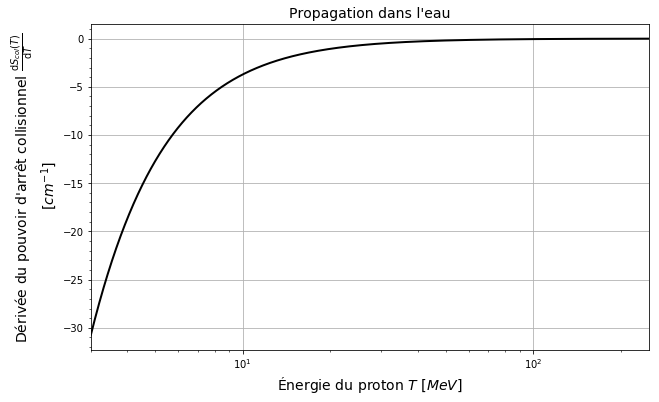

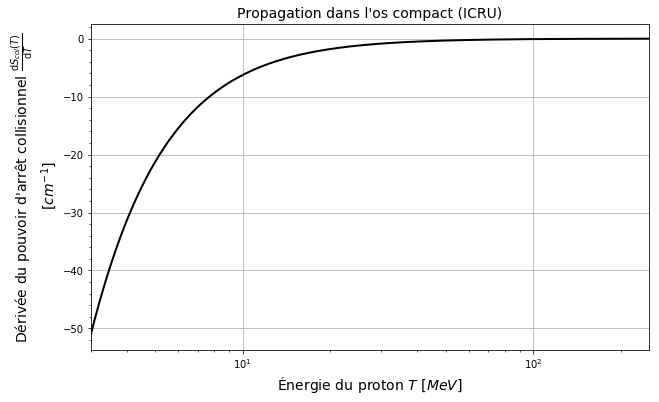

In [14]:
water.plot_Scol_derivative()
icru.plot_Scol_derivative()

### Question 7

**Tableau 1 : Portée calculée par différentes méthodes d'intégration et les erreurs d'approximation correspondantes.**<br>

| Méthode d'intégration | Milieu de propagation | Portée $R_{CSDA}$ | Erreur d'approximation calculé | Erreur d'approximation pratique |
|:---------------------:|:---------------------:|:-----------------:|:------------------------------:|:-------------------------------:|
|          -             |            -           |     *[g/cm^2]*    |           *[g/cm^2]*           |            *[g/cm^2]*           |
|        Trapèze        |          Eau<br><br>Os compact (ICRU)          |        15.752318548926102<br><br>16.94448335078685           |        0<br><br>0                        |      2.3684757858670005$\cdot$ 10$^{-15}$ <br><br>1.1842378929335002$\cdot$ 10$^{-15}$      |
|        Simpson        |          Eau<br><br>Os compact (ICRU)          |       15.752318548926093<br><br>16.944483350786847            |                -<br>-               |                1.7763568394002505$\cdot$ 10$^{-15}$<br><br>2.1316282072803005$\cdot$ 10$^{-15}$                 |

Observation

## Optimisation

### Question 8

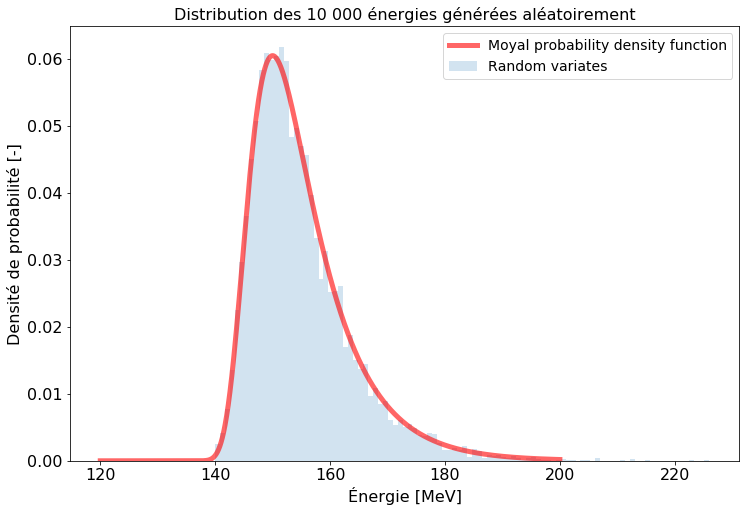

In [15]:
"""
La distribution en énergie des protons est approximée à l'aide d'une distribution de Moyal.

"""

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)

x = np.linspace(120, 200, 10000)
y = moyal.pdf(x, loc=150, scale=4)
ax.plot(x, y, 'r-', lw=5, alpha=0.6, label='moyal pdf')

distribution = moyal.rvs(loc=150, scale=4, size=10000)
ax.hist(distribution, density=True, histtype='stepfilled', alpha=0.2, bins=100)


plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
ax.set_title("Distribution des 10 000 énergies générées aléatoirement", fontsize=16)
ax.set_xlabel("Énergie [MeV]", fontsize=16)
ax.set_ylabel("Densité de probabilité [-]", fontsize=16)
ax.legend(["Moyal probability density function", "Random variates"], fontsize=14, loc='best')
fig = plt.gcf()
plt.show()


### Question 9

In [16]:
"""
La portée des protons est calculée à l'aide des trois techniques d'intégration et
le temps d'excécution est calculé pour chacune afin de déterminer le nombre de protons calculés par seconde.
Les 10 000 énergies générées aléatoirement à la section précédente sont utilisées pour faire les intégrations.

L'erreur par défaut de la routine de scipy.integrate est de 1.49e-8 
(https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html)

La section suivante exécute les calculs de la portée des protons dans l'eau liquide. 

"""

min_energy = 3
error_target = 1.49e-8
nb_proton = 10000

water = Medium(name="Water")
function_water = lambda T: water.density/water.get_Scol(T)
water_integration = Integration(function_water)


starttime = timeit.default_timer()
water_scipy = []

for i in distribution:
    I = integrate.quad(function_water, min_energy, i)
    water_scipy.append(I[0])


nb_proton_scipy = nb_proton/(timeit.default_timer()-starttime)
print("Nombre de protons par seconde avec scipy = ", nb_proton_scipy, "protons/s")


starttime = timeit.default_timer()
water_trapeze_integral = []  


for i in distribution:  
    I = water_integration.integrate(algo='trapeze', a=min_energy, b=i, output_format="tuple", 
                                                         error_target=error_target)
    water_trapeze_integral.append(I[0])

    
nb_proton_trapeze = nb_proton/(timeit.default_timer()-starttime)
print("Nombre de protons par seconde avec trapeze = ", nb_proton_trapeze, "protons/s")


starttime = timeit.default_timer()
water_simpson_integral = []    


for i in distribution:    
    I = water_integration.integrate(algo='simpson', a=min_energy, b=i, output_format="tuple", 
                                                        error_target=error_target)
    water_simpson_integral.append(I[0])
    
nb_proton_simpson = nb_proton/(timeit.default_timer()-starttime)
print("Nombre de protons par seconde avec simpson = ", nb_proton_simpson, "protons/s")

Nombre de protons par seconde avec scipy =  720.8201757221208 protons/s
Nombre de protons par seconde avec trapeze =  439.13308103673984 protons/s
Nombre de protons par seconde avec simpson =  751.5659063550366 protons/s


In [17]:
"""
La section suivante exécute les calculs dans l'os compact. 

"""

icru = Medium(name="ICRU")
function_icru = lambda T: icru.density/icru.get_Scol(T)
icru_integration = Integration(function_icru)


starttime = timeit.default_timer()
icru_scipy = []

for i in distribution:
    I = integrate.quad(function_icru, min_energy, i)
    icru_scipy.append(I[0])



nb_proton_scipy = nb_proton/(timeit.default_timer() - starttime)
print("Nombre de protons par seconde avec scipy = ", nb_proton_scipy, "protons/s")


starttime = timeit.default_timer()
icru_trapeze_integral = []  


for i in distribution:  
    I = icru_integration.integrate(algo='trapeze', a=min_energy, b=i, output_format="tuple", 
                                                         error_target=error_target)
    icru_trapeze_integral.append(I[0])

    
nb_proton_trapeze = nb_proton/(timeit.default_timer() - starttime)
print("Nombre de protons par seconde avec trapeze = ", nb_proton_trapeze, "protons/s")


starttime = timeit.default_timer()
icru_simpson_integral = []    


for i in distribution:    
    I = icru_integration.integrate(algo='simpson', a=min_energy, b=i, output_format="tuple", 
                                                        error_target=error_target)
    icru_simpson_integral.append(I[0])
    
nb_proton_simpson = nb_proton/(timeit.default_timer() - starttime)
print("Nombre de protons par seconde avec simpson = ", nb_proton_simpson, "protons/s")



Nombre de protons par seconde avec scipy =  740.9641880967545 protons/s
Nombre de protons par seconde avec trapeze =  444.074727562929 protons/s
Nombre de protons par seconde avec simpson =  733.1163201501998 protons/s


### Question 10

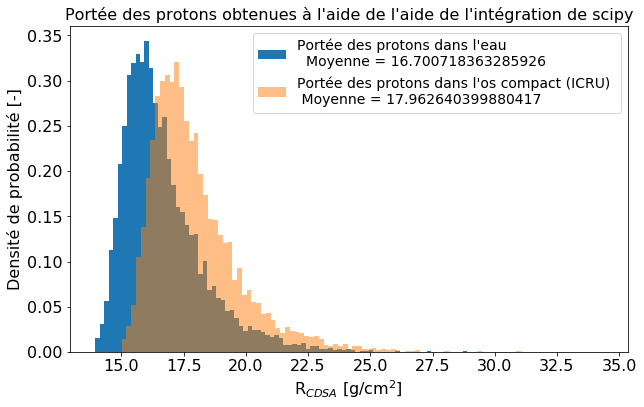

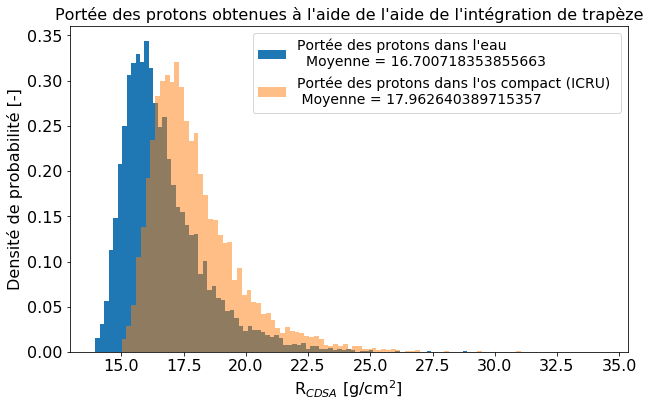

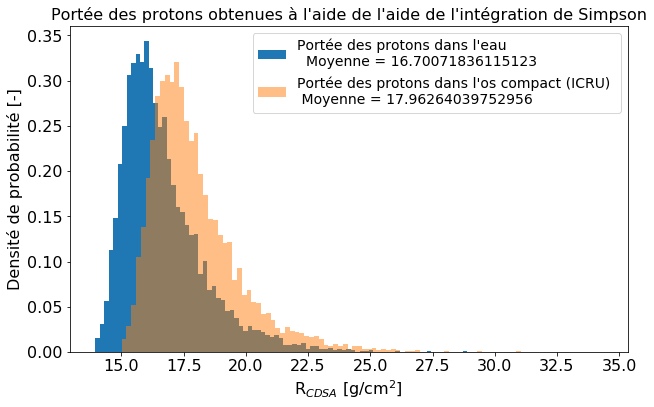

In [18]:
"""
Histogrammes des portées obtenues pour la distribution des 10 000 protons
à l'aide des trois techniques d'intégration.

"""

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

ax.hist(water_scipy, density=True, histtype='stepfilled', bins=100)
ax.hist(icru_scipy, density=True, histtype='stepfilled', alpha=0.5, bins=100)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
ax.set_title("Portée des protons obtenues à l'aide de l'aide de l'intégration de scipy", fontsize=16)
ax.set_xlabel("R$_{CDSA}$ [g/cm$^2$]", fontsize=16)
ax.set_ylabel("Densité de probabilité [-]", fontsize=16)
ax.legend(["Portée des protons dans l'eau \n  Moyenne = {}".format(np.mean(water_scipy)),
           "Portée des protons dans l'os compact (ICRU) \n Moyenne = {}".format(np.mean(icru_scipy))], 
          fontsize=14, loc='best')
fig = plt.gcf()
plt.show()



fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

ax.hist(water_trapeze_integral, density=True, histtype='stepfilled', bins=100)
ax.hist(icru_trapeze_integral, density=True, histtype='stepfilled', alpha=0.5, bins=100)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
ax.set_title("Portée des protons obtenues à l'aide de l'aide de l'intégration de trapèze", fontsize=16)
ax.set_xlabel("R$_{CDSA}$ [g/cm$^2$]", fontsize=16)
ax.set_ylabel("Densité de probabilité [-]", fontsize=16)
ax.legend(["Portée des protons dans l'eau \n  Moyenne = {}".format(np.mean(water_trapeze_integral)),
           "Portée des protons dans l'os compact (ICRU) \n Moyenne = {}".format(np.mean(icru_trapeze_integral))], 
          fontsize=14, loc='best')
fig = plt.gcf()
plt.show()



fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

ax.hist(water_simpson_integral, density=True, histtype='stepfilled', bins=100)
ax.hist(icru_simpson_integral, density=True, histtype='stepfilled', alpha=0.5, bins=100)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
ax.set_title("Portée des protons obtenues à l'aide de l'aide de l'intégration de Simpson", fontsize=16)
ax.set_xlabel("R$_{CDSA}$ [g/cm$^2$]", fontsize=16)
ax.set_ylabel("Densité de probabilité [-]", fontsize=16)
ax.legend(["Portée des protons dans l'eau \n  Moyenne = {}".format(np.mean(water_simpson_integral)),
           "Portée des protons dans l'os compact (ICRU) \n Moyenne = {}".format(np.mean(icru_simpson_integral))], 
          fontsize=14, loc='best')
fig = plt.gcf()
plt.show()


### Question 11

In [144]:
"""
la section suivante sert à calculer l'énergie déposée par un proton
dans un écrmément de déplacement s dans l'eau et dans l'os compact (ICRU).

"""

max_energy = 150 # MeV
min_energy = 0.01 # MeV
energy_vector = np.linspace(max_energy,min_energy,5000) # linspace des énergies finales du transport
err = 1*10**-4


water = Medium(name="Water")
icru = Medium(name="ICRU")

function_water = lambda T: 1/water.get_Scol(T)
function_icru = lambda T: 1/icru.get_Scol(T)

icru_integration = Integration(function_icru)
water_intergration = Integration(function_water)

absorbed_energy = []
D_icru = []
D_water = []

for energy in range(len(energy_vector)-1):
    D_icru.append(icru_integration.integrate(algo='simpson', a=energy_vector[energy+1], b=energy_vector[energy], 
                                             output_format="tuple", error_target = err)[0])
    
    D_water.append(water_integration.integrate(algo='simpson', a=energy_vector[energy+1], b=energy_vector[energy], 
                                             output_format="tuple", error_target = err)[0])
    
    absorbed_energy.append(energy_vector[energy]-energy_vector[energy+1])

D_icru = np.asarray(D_icru)
D_water = np.asarray(D_water)


I_water=np.cumsum(D_water)
I_icru=np.cumsum(D_icru)

absorbed_energy_mat = np.asarray(absorbed_energy)
I_water_mat = np.asarray(I_water)
I_icru_mat = np.asarray(I_icru)
                    

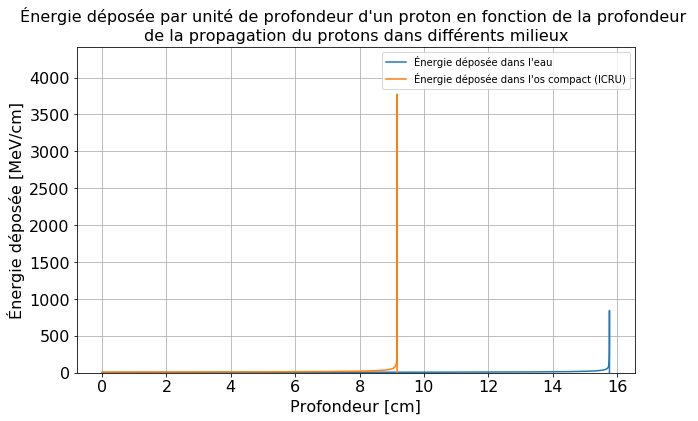

portée des protons dans l'eau =  15.76683504893256 g/cm^2
portée des protons dans l'os compact =  16.960522222168766 g/cm^2


In [145]:
"""
la section suivante sert à mettre en graphique la relation entre l'énergie déposée par le proton par unité de profondeur et 
la profondeur elle-même. Cette coubre se nomme la courbe de Bragg.

"""

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(I_water_mat,absorbed_energy_mat/D_water)
ax.plot(I_icru_mat,absorbed_energy_mat/D_icru)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
ax.set_title("Énergie déposée par unité de profondeur d'un proton en fonction de la profondeur \n"
             "de la propagation du protons dans différents milieux", 
             fontsize=16)
ax.set_ylabel("Énergie déposée [MeV/cm]", fontsize=16)
ax.set_xlabel("Profondeur [cm]", fontsize=16)
ax.set_ylim(0)
ax.grid('True')
#ax.set_yscale('log')
ax.legend(["Énergie déposée dans l'eau", "Énergie déposée dans l'os compact (ICRU)"])

fig = plt.gcf()
plt.show()


print("portée des protons dans l'eau = ", max(I_water)*water.density, "g/cm^2")
print("portée des protons dans l'os compact = ", max(I_icru)*icru.density, "g/cm^2")

Comme prévu, la position des zéros obtenus correspondent bien aux portées des protons dans chacun des milieux si on mulitplie la valeur obtenue distance par la densité du milieu respectif. En effet, la seule différence entre l'intégration réalisée pour la portée et celle utilisée ici est l'inclusion de la densité du matériau. En comparant les deux courbes et suite à expérimentation, il est déterminé que la position du zéro sur la courbe obtenu est donc influencée par l'énergie du faisceau de photon utilisé ainsi que par les propriétés du milieu de propagation telle que la densité.

### Question 12
L'intérêt des protons pour la radiotherapy est que, comme il est possible de voir par les courbes de Bragg, la bande de profondeur à laquelle l'énergie est majoritairement absorbée est très mince. Cela permet alors de bien contrôller la profondeur à laquelle le traitement doit être fait en modifiant l'énergie du faisceau de protons utilisé et ainsi d'offrir un traitement qui intéragit peu avec les tissus en santé non-visés. Un avantage d'utiliser une telle méthode est donc de réduire le plus possible la radiation non désirable que le patient recoit pendant le traitement.

### Question 13


In [141]:
"""
Dans cette section, un algorithme permettant de calculer l'énergie du faisceau de protons à partir de la distance
de pénétration voulue D est réalisé.
"""


In [ ]:
"""
Dans cette section, le calcul de l'énergie du faisceau nécessaire à opérer sur mélanome à une distance de 4 cm
sous la surface occulaire est réalisé.
"""

### Question 14 
Les protons sont préférables aux photons pour traiter les mélanome occulaire pour plusieurs raisons. Par exemple, si on compare les courbes de Bragg du proton et du neutron, on remarque que la profondeur à laquelle l'énergie est majoritairement absorbée est plutôt étroite ce qui est avantageux en général pour le traitement de tumeurs contraiement aux protons qui possèdent une courbe plus étalée [(source)](https://www.iaslc.org/iaslc-news/ilcn/proton-beam-therapy-versus-photon-beam-therapy-debate-continues#:~:text=Photons%20Versus%20Protons,-Although%20the%20therapeutic&text=Unlike%20photons%2C%20which%20deposit%20their,majority%20of%20energy%20deposition%20occurs.). En effet, c'est souvent le faible impact qu'à la protonthérapie sur les tissus environnants la tumeur qui fait que celle-ci est préférée au photons lors du traitement de tumeurs dans la région occulaire [(source 1)](https://eyecancer.com/eye-cancer/treatments/proton-beam-versus-plaque/) [(source 2)](https://www.ucsfhealth.org/treatments/proton-therapy-for-ocular-melanoma#:~:text=Proton%20therapy%20is%20considered%20the,maintaining%20a%20patient's%20natural%20eye.). De plus, contrairement aux photons les neutrons ne tendent pas à se propager beaucoup plus loin que le pic de bragg ce qui est un avantage lorsqu'il faut épargner les composantes de l'oeil plus profondes telle que la tétine.

### Question 15
Dans l'approche présentement utilisée, on prend pour acquis que le faisceau de proton utilisé se propage en ligne droite. Cela n'est pas totalement réaliste puisqu'il y a en effet de la diffusion lorsque les protons se propagent à travers la matière.